In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, RepeatVector, TimeDistributed
import tensorflow.keras.layers as layers

In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'

## 2D CNN LSTM model

In [71]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'
'''
model = Sequential()

model.add(
    TimeDistributed(
        Conv2D(20, (1,1), activation='relu', 
               padding='same', 
               input_shape=(n_features_row, n_features_column, no_channel)),
               input_shape=(time_step,n_features_row, n_features_column, no_channel)))
model.add(
    TimeDistributed(
        Conv2D(20, (1,1), activation='relu', 
               padding='same', 
               input_shape=(n_features_row, n_features_column, no_channel)),
               input_shape=(time_step,n_features_row, n_features_column, no_channel)))

model.add(
    TimeDistributed(
        MaxPooling2D(pool_size=(2, 2))))
        
model.add(TimeDistributed(Flatten()))


#model.add(TimeDistributed(Flatten(),input_shape=(time_step,n_features_row, n_features_column, no_channel)))

#model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
#model.add(Dense(100, kernel_initializer='glorot_normal', activation='relu'))

#model.add(Flatten())

model.add(Dense(Y_train.shape[1]))

model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)
'''

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)
LSTM_layer1 = LSTM(50)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "2DCNN_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 52, 100, 100, 20)  40        
_________________________________________________________________
time_distributed_30 (TimeDis (None, 52, 100, 100, 20)  420       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 52, 50, 50, 20)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 52, 50000)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                10010200  
_________________________________________________________________
dense_20 (Dense)             (None, 100)               5

In [72]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_mae',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=20, 
                             batch_size=10, 
                             #callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             #earlystop_callback,
                             #model_checkpoint_callback]
                                   )

Train on 88 samples, validate on 28 samples
Epoch 1/20
88/88 [==============================] - 3s 29ms/sample - loss: 0.0080 - mae: 0.0080 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 2/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0057 - mae: 0.0057 - val_loss: 0.0047 - val_mae: 0.0047
Epoch 3/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0039 - mae: 0.0039 - val_loss: 0.0033 - val_mae: 0.0033
Epoch 4/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0029 - mae: 0.0029 - val_loss: 0.0026 - val_mae: 0.0026
Epoch 5/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 6/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0022 - val_mae: 0.0022
Epoch 7/20
88/88 [==============================] - 1s 15ms/sample - loss: 0.0021 - mae: 0.0021 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 8/20
88/88 [=======

In [73]:
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0019 - mae: 0.0019
valid_accuracy_MAE=0.0019030821, valid_loss=0.0019030821276828647


In [74]:
Predict = model.predict(X_valid)

In [75]:
Predict.shape

(28, 10000)

In [76]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [77]:
def reshapePred(Predict):
    return np.rot90(Predict[-1].reshape(int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))))

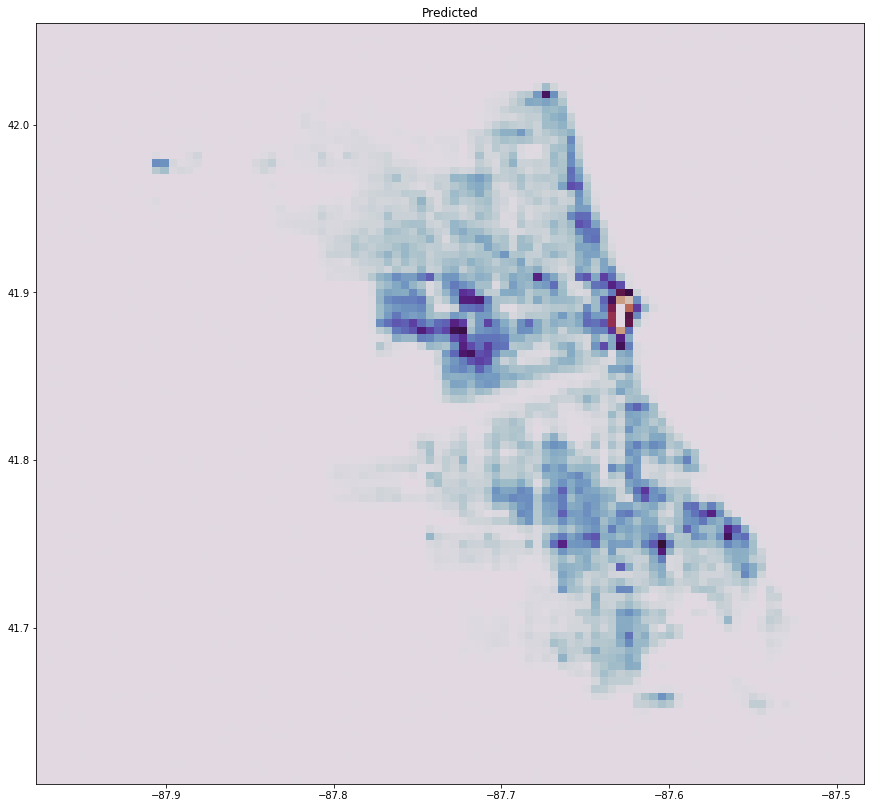

In [78]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

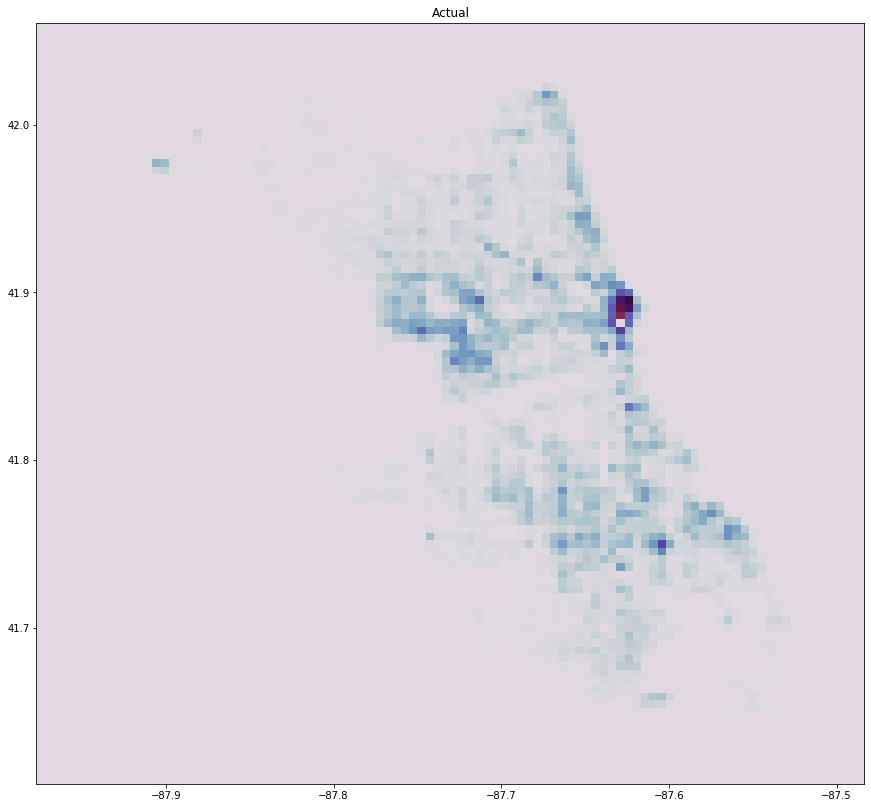

In [79]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])